<a href="https://colab.research.google.com/github/pdrzxzz/satellite-image-classification/blob/main/micro_organism_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle
!pip install albumentations

In [ ]:
# ============================== #
#         Import Libraries       #
# ============================== #

# Essential libraries for machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing from albumentations (Image augmentation)
import albumentations as A

# Image processing from skimage
from skimage import img_as_ubyte # Convert grayscale image to unsigned 8-bit format (required by LBP)
from skimage.io import imread  # To read image files
from skimage.transform import resize  # To resize images
from skimage.feature import local_binary_pattern  # To extract texture
from skimage import filters # sobel, prewitt... # To extract edges

# Scikit-learn Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Scikit-learn modules for training and evaluation
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Utilities
import kagglehub  # To download datasets directly from Kaggle using KaggleHub
import os  # For interacting with the operating system, such as file paths
import joblib # Save models

In [ ]:
# ========================================== #
#      Constants and Configurations          #
# ========================================== #

# Features to be extracted from images
# FEATURES = ['gray', 'color', 'lbp', 'sobel']
FEATURES = ['gray']

# Number of images to use from each class (can be limited for faster runs or place a huge value to use all the images)
NUM_IMAGES_PER_CLASS = 100000

# Size to which all images will be resized (width, height)
IMAGE_SIZE = (16, 16)

# Parameters for Local Binary Patterns (LBP)
LBP_RADIUS = 1                  # Radius of circle for LBP
LBP_N_POINTS = 8 * LBP_RADIUS  # Number of points to consider in LBP

# Random state for reproducibility in splitting and models
RANDOM_STATE = 0

# Define default augmentation pipeline
AUGMENTATION_PIPELINE = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2),
    A.Rotate(limit=15, p=0.3),
])

In [ ]:
# ============================== #
#        Download Dataset        #
# ============================== #

# Download dataset from Kaggle using KaggleHub
path = kagglehub.dataset_download("mdwaquarazam/microorganism-image-classification")

# Path to the folder containing the image dataset
data_path = os.path.join(path, os.listdir(path)[0])

# List all image classes (subdirectories) in the dataset folder, sorted for consistency
image_classes = sorted(os.listdir(data_path))

# Print dataset location and classes found for confirmation
print("Dataset directory:", data_path)
print("Classes found:", image_classes)

Dataset directory: /kaggle/input/microorganism-image-classification/Micro_Organism
Classes found: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


In [ ]:
# ========================================== #
#      Image Processing & Feature Utils      #
# ========================================== #

def load_and_resize_image(image_path, as_gray=True, augment=True):
    """
    Load an image from disk, resize it, optionally apply augmentation, and return the result.

    Parameters:
    - image_path (str): Path to the image file.
    - as_gray (bool): Load the image as grayscale if True; otherwise, as color.
    - augment (bool): Whether to apply Albumentations image augmentation.

    Returns:
    - np.ndarray: The resized (and possibly augmented) image.
    """
    image = imread(image_path, as_gray=as_gray)
    image = resize(image, IMAGE_SIZE, anti_aliasing=True)

    if augment:
        # Convert to uint8 format required by Albumentations
        image_uint8 = img_as_ubyte(image)

        if as_gray:
            # Albumentations expects grayscale images to have shape (H, W, 1)
            image_uint8 = image_uint8[..., np.newaxis]

        # Apply augmentation pipeline
        augmented = AUGMENTATION_PIPELINE(image=image_uint8)
        image_aug = augmented["image"]

        # Convert back to float32 normalized between 0 and 1
        image_aug = image_aug.astype(np.float32) / 255.0

        if as_gray:
            image_aug = image_aug[..., 0]  # Remove channel dimension

        return image_aug

    return image

def extract_color_histograms(image):
    """
    Extract 256-bin histogram features for each RGB channel and concatenate.

    Parameters:
    - image (np.ndarray): Color image array.

    Returns:
    - np.ndarray: Concatenated histogram vector (length 256 * 3 = 768).
    """

    # If image is grayscale, convert it to 3-channel by repeating it
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)

    # For each color channel (R,G,B), compute histogram counts
    histograms = [
        np.histogram(image[:, :, channel], bins=256, range=(0, 256))[0]
        for channel in range(3)
    ]
    # Concatenate histograms of all channels into one feature vector
    concatenated_hist = np.concatenate(histograms)
    return concatenated_hist

def extract_lbp_features(gray_image):
    """
    Compute Local Binary Pattern (LBP) histogram for a grayscale image.

    Parameters:
    - gray_image (np.ndarray): Grayscale image array.

    Returns:
    - np.ndarray: Normalized histogram of LBP patterns.
    """
    # Convert grayscale image to unsigned 8-bit format (required by LBP)
    image_uint8 = img_as_ubyte(gray_image)

    # Compute LBP using 'uniform' method
    lbp = local_binary_pattern(image_uint8, LBP_N_POINTS, LBP_RADIUS, method="uniform")

    # Define number of bins for histogram
    n_bins = LBP_N_POINTS + 2  # Number of possible LBP patterns in uniform method

    # Calculate normalized histogram of LBP
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return lbp_hist

In [ ]:
# ========================================== #
#          Dataset Feature Extraction        #
# ========================================== #

def process_dataset_from_paths(image_paths, labels, features=["gray"], augment=False):
    """
    Load dataset images, extract selected features and encode labels.

    Parameters:
    - features (list of str): Feature types to extract.
        Options include 'gray', 'color', 'lbp', 'sobel', 'prewitt'.

    Returns:
    - X (np.ndarray): Feature matrix of shape (num_samples, num_features).
    - y (np.ndarray): Encoded integer labels for each sample.
    """
    # Dictionary to hold lists of extracted features per feature type
    feature_arrays = {f: [] for f in features}
    labels = []

    # Iterate over each class folder
    for image_class in image_classes:
        print(f"Processing class: {image_class}")
        class_path = os.path.join(data_path, image_class)

        for idx, img_path in enumerate(image_paths):
            label = os.path.basename(os.path.dirname(img_path))
            labels.append(label)
            gray = load_and_resize_image(img_path, as_gray=True, augment=augment)

            # Extract and append grayscale flattened pixels if requested
            if "gray" in features:
                feature_arrays["gray"].append(gray.flatten())

            # Extract and append color histograms if requested
            if "color" in features:
                color_img = load_and_resize_image(img_path, as_gray=False, augment=augment)
                feature_arrays["color"].append(extract_color_histograms(color_img))

            # Extract and append LBP histogram if requested
            if "lbp" in features:
                feature_arrays["lbp"].append(extract_lbp_features(gray))

            # Extract and append Sobel edge features if requested
            if "sobel" in features:
                sobel_img = filters.sobel(gray)
                feature_arrays["sobel"].append(sobel_img.flatten())

            # Extract and append Prewitt edge features if requested
            if "prewitt" in features:
                prewitt_img = filters.prewitt(gray)
                feature_arrays["prewitt"].append(prewitt_img.flatten())

            # Progress print on the same line for convenience
            print(f"\r{idx + 1}/{len(image_paths)}", end="", flush=True)
        print()  # New line after finishing a class

    # List to hold scaled feature arrays for each requested feature type
    scaled_features = []

    # Normalize each feature array independently using StandardScaler (mean=0, std=1)
    for f in features:
        array = np.array(feature_arrays[f])
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(array)
        scaled_features.append(scaled_array)

    # Concatenate features horizontally if multiple feature types requested
    if len(scaled_features) > 1:
        X = np.concatenate(scaled_features, axis=1)
    else:
        X = scaled_features[0]

    # Return final feature matrix and encoded labels as numpy arrays
    return X, labels

In [ ]:
# ========================================== #
#      Model Evaluation and Visualization    #
# ========================================== #

def plot_learning_curve(model, X, y, title="Learning Curve", scoring="accuracy", cv_splits=5):
    """
    Plot the learning curve for a given model and dataset.

    Parameters:
    - model (estimator): A scikit-learn estimator (e.g., RandomForestClassifier).
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Target labels.
    - title (str): Title for the plot.
    - scoring (str): Metric to evaluate model performance (default = 'accuracy').
    - cv_splits (int): Number of cross-validation folds.
    """
    # Create a stratified K-fold split strategy
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

    # Define relative sizes of training data to evaluate
    train_sizes = np.linspace(0.05, 0.95, 19)

    # Compute training and validation scores for different training sizes
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    # Compute mean and standard deviation for error bands
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(train_sizes_abs, val_mean, 'o-', label='Validation Accuracy', color='green')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

    # X-axis in percentage form for clarity
    percent_labels = [f"{int(p * 100)}%" for p in train_sizes]
    plt.xticks(train_sizes_abs, percent_labels, rotation=45)

    # Set plot titles and labels
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# ========================================== #
#                  Training                  #
# ========================================== #

def train_grid_search(classifier, param_grid, X_train, X_test, y_train, y_test):
    """
    Perform hyperparameter tuning with GridSearchCV on Classifier.

    Parameters:
    - classifier: estimator object (e.g. RandomForestClassifier)
    - param_grid: dict, hyperparameters grid for GridSearchCV
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Labels.

    Returns:
    - best_model (estimator): Best estimator after grid search.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=3
    )
    grid_search.fit(X_train, y_train)
    print("Best hyperparameters found:", grid_search.best_params_)
    test_accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))
    print(f"Test accuracy with best model: {test_accuracy:.4f}")
    return grid_search.best_estimator_


In [ ]:
# ========================================== #
#                Run Pipeline                #
# ========================================== #

# Step 1: List all image paths and labels
image_paths = []
labels = []

for image_class in image_classes:
    class_path = os.path.join(data_path, image_class)
    image_list = os.listdir(class_path)[:NUM_IMAGES_PER_CLASS]
    for image_file in image_list:
        image_paths.append(os.path.join(class_path, image_file))
        labels.append(image_class)

# Step 2: Encode labels
labels_encoded = LabelEncoder().fit_transform(labels)

# Step 3: Split into train/test before feature extraction
train_paths, test_paths, y_train, y_test = train_test_split(
    image_paths,
    labels_encoded,
    stratify=labels_encoded,
    test_size=0.1,
    shuffle=True,
    random_state=RANDOM_STATE
)

# Step 4: Extract features separately
X_train, y_train = process_dataset_from_paths(train_paths, y_train, features=FEATURES, augment=True)
X_test, y_test   = process_dataset_from_paths(test_paths, y_test, features=FEATURES, augment=False)

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

# Concatenate full dataset for learning curve
X = np.concatenate([X_train_pca, X_test_pca], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Processing class: Amoeba
710/710
Processing class: Euglena
710/710
Processing class: Hydra
710/710
Processing class: Paramecium
710/710
Processing class: Rod_bacteria
710/710
Processing class: Spherical_bacteria
710/710
Processing class: Spiral_bacteria
710/710
Processing class: Yeast
710/710
Processing class: Amoeba
79/79
Processing class: Euglena
79/79
Processing class: Hydra
79/79
Processing class: Paramecium
79/79
Processing class: Rod_bacteria
79/79
Processing class: Spherical_bacteria
79/79
Processing class: Spiral_bacteria
79/79
Processing class: Yeast
79/79


In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=20;, score=0.183 total time=   0.2s
[CV 2/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=20;, score=0.229 total time=   0.2s
[CV 3/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=20;, score=0.178 total time=   0.2s
[CV 4/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=20;, score=0.242 total time=   0.2s
[CV 5/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=20;, score=0.182 total time=   0.2s
[CV 1/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=30;, score=0.180 total time=   0.3s
[CV 2/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=30;, score=0.224 total time=   0.3s
[CV 3/5] END max_depth=2, min_samples_leaf=8, min_samples_split=6, n_estimators=30;, score=0.179 total time=   0.3s
[CV 4/5] E

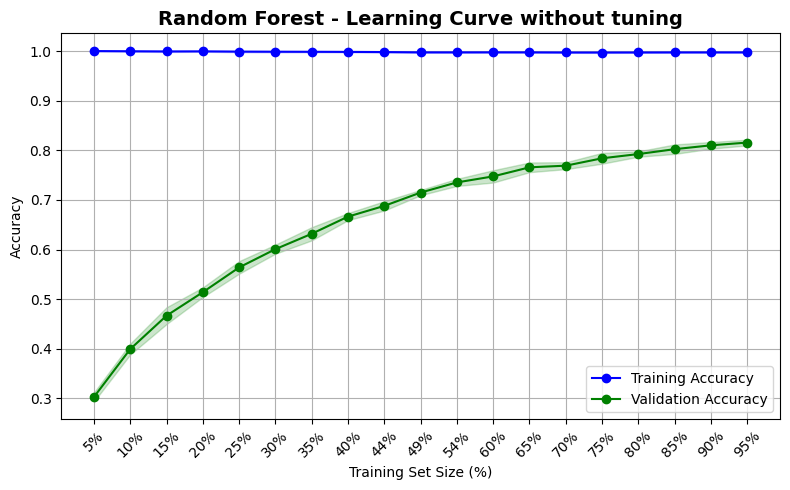

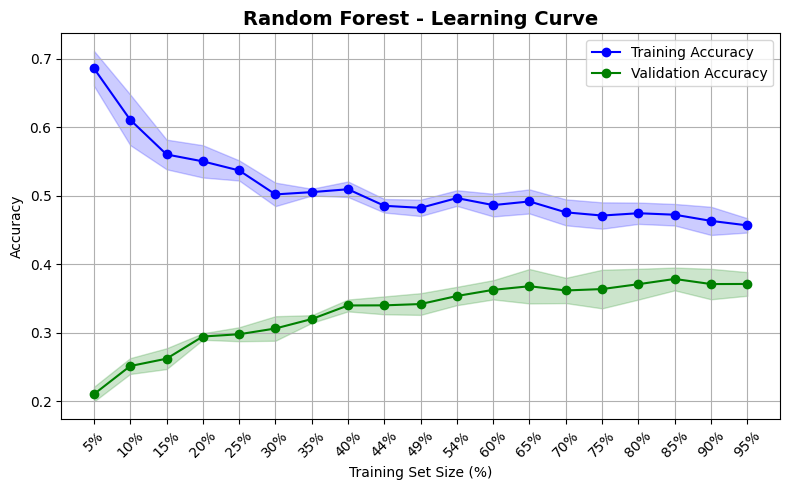

[[ 8  0  0  0  0 16  0 32]
 [16 48 16  0  0 40  0 16]
 [ 0  8 24  8  0  0  8 16]
 [ 0  8 32  8  8 32  0 32]
 [ 0  8  8  8  0 16 16 16]
 [ 8  0  8  8  0 16  8 24]
 [ 8  0  8  0  8  8  8 16]
 [ 0  8  0  0  0  8  0 40]]


In [ ]:
# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [20, 30, 40],            # Number of trees
    'max_depth': [2, 3, 5],           # Max depth of trees
    'min_samples_split': [6, 24, 48],           # Min samples required to split node
    'min_samples_leaf': [8, 16],             # Min samples required at leaf node
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced")

best_rf_model = train_grid_search(rf_model, param_grid_rf, X_train, X_test, y_train, y_test)

plot_learning_curve(RandomForestClassifier().fit(X_train, y_train), X, y, title="Random Forest - Learning Curve without tuning")
plot_learning_curve(best_rf_model, X, y, title="Random Forest - Learning Curve")
print(classification_report(y_test, best_rf_model.predict(X_test)))
print(confusion_matrix(y_test, best_rf_model.predict(X_test)))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.415 total time=   0.4s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.423 total time=   0.4s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.415 total time=   0.3s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.446 total time=   0.3s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.444 total time=   0.2s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.680 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.658 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.646 total time=   0.2s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.670 total time=   0.2s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=

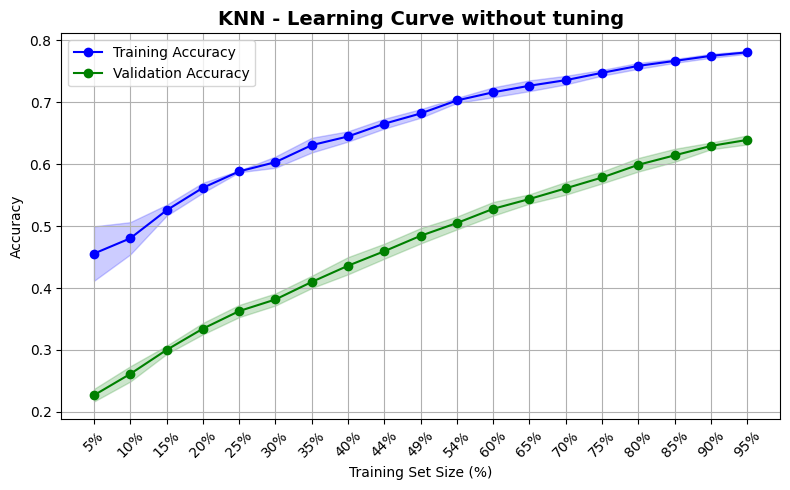

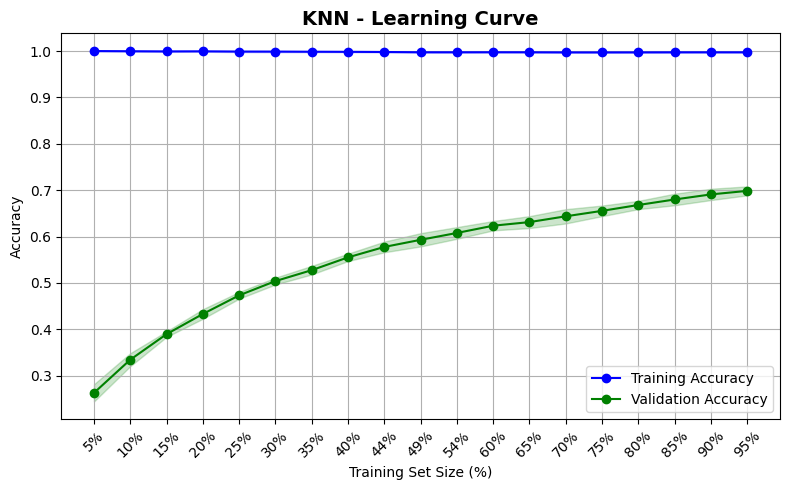

                    precision    recall  f1-score   support

            Amoeba       0.22      0.29      0.25        56
           Euglena       0.33      0.29      0.31       136
             Hydra       0.00      0.00      0.00        64
        Paramecium       0.25      0.40      0.31       120
      Rod_bacteria       0.25      0.11      0.15        72
Spherical_bacteria       0.00      0.00      0.00        72
   Spiral_bacteria       0.00      0.00      0.00        56
             Yeast       0.15      0.29      0.20        56

          accuracy                           0.20       632
         macro avg       0.15      0.17      0.15       632
      weighted avg       0.18      0.20      0.18       632

[[16  8  0  8  0  0  0 24]
 [16 40  0 56  0  0  8 16]
 [ 8  0  0 32  8  8  0  8]
 [16 32  0 48  8  8  8  0]
 [ 0 16  0  8  8 16 16  8]
 [ 0 16  8 24  0  0  0 24]
 [16  0 16  8  8  0  0  8]
 [ 0  8  0  8  0  8 16 16]]


In [ ]:
# KNN
param_grid_knn = {
    'n_neighbors': [15, 30, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean'],
}

knn_model = KNeighborsClassifier()
best_knn_model = train_grid_search(knn_model, param_grid_knn, X_train, X_test, y_train, y_test)

plot_learning_curve(KNeighborsClassifier().fit(X_train, y_train), X, y, title="KNN - Learning Curve without tuning")
plot_learning_curve(best_knn_model, X, y, title="KNN - Learning Curve")
print(classification_report(y_test, best_knn_model.predict(X_test)))
print(confusion_matrix(y_test, best_knn_model.predict(X_test)))

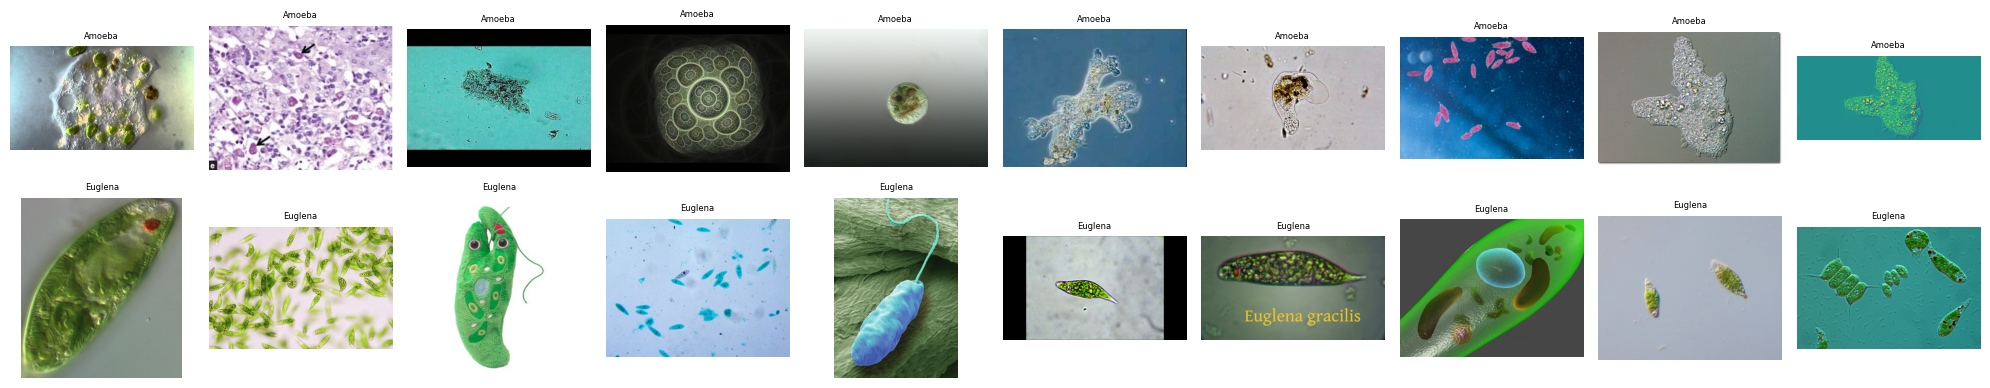

In [ ]:
N = 20
rows = N // 10
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(N):
    image = imread(image_paths[i])
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(labels[i], fontsize=6)

plt.tight_layout()
plt.show()
